# Warping of images

In [1]:
import cv2 as cv
from matplotlib import pyplot as plt
import numpy as np

(1776, 1200, 3)


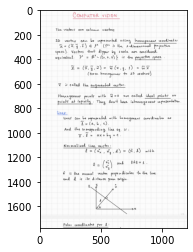

In [125]:
# Load image
img = cv.imread(cv.samples.findFile("../assets/handwritten.jpg"))
print(img.shape)

# Ploting the image requires to transform RGB to BGR
plt.imshow(img[:,:,::-1])
plt.show()

## Affine transformations

In [126]:
# Points at origin and at destination.
src_points = np.array(
    [[0, 0], 
     [img.shape[1] - 1, 0], 
     [0, img.shape[0] - 1]]
).astype(np.float32)

dst_points = np.array(
    [[0, img.shape[1] * 0.20], 
     [img.shape[1] * 0.90, img.shape[0] * 0.25], 
     [img.shape[1] * 0.15, img.shape[0] * 0.8]]
).astype(np.float32)

print("Points at origin:\n", src_points)
print("Points at destination:\n", dst_points)

Points at origin:
 [[   0.    0.]
 [1199.    0.]
 [   0. 1775.]]
Points at destination:
 [[   0.   240. ]
 [1080.   444. ]
 [ 180.  1420.8]]


In [127]:
# Computing warping matrix
warp_mat = cv.getAffineTransform(src_points, dst_points)
print("Warp matrix:\n", warp_mat)

Warp matrix:
 [[9.00750626e-01 1.01408451e-01 0.00000000e+00]
 [1.70141785e-01 6.65239464e-01 2.40000000e+02]]


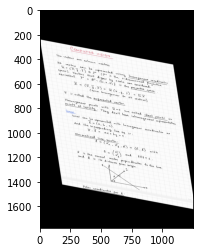

In [128]:
# Computing warped image according to the matrix. In this code, I can form my
# own matrix, and then apply the affine transformation without go through the
# definition of points.
warp_img = cv.warpAffine(img, warp_mat, (img.shape[1] + 50, img.shape[0]))
plt.imshow(warp_img[:,:,::-1])
plt.show()

## Rotations

In [129]:
center = (img.shape[1] / 2, img.shape[0] / 2)
angle = 45
scale = 0.70
rot_mat = cv.getRotationMatrix2D(center, angle, scale)

print("Rotation matrix:\n", rot_mat)

Rotation matrix:
 [[ 4.94974747e-01  4.94974747e-01 -1.36522423e+02]
 [-4.94974747e-01  4.94974747e-01  7.45447273e+02]]


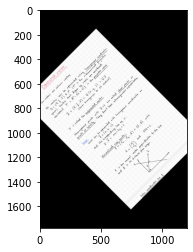

In [130]:
img_dst = cv.warpAffine(img, rot_mat, (img.shape[1], img.shape[0]))

plt.imshow(img_dst[:, :, ::-1])
plt.show()

## Perspective transformations

In [132]:
# Points at origin and at destination
src_points = np.array([
    [0, 0],
    [0, img.shape[1] - 1],
    [img.shape[0] - 1, 0],
    [img.shape[0] - 1, img.shape[1] - 1],
]).astype(np.float32)

dst_points = np.array([
    [100, 100],
    [20, img.shape[1] * 0.70],
    [img.shape[0] * 0.90, 0],
    [img.shape[0] * 0.95, img.shape[1] * 0.80],
]).astype(np.float32)

print("Points at origin:\n", src_points)
print("Points at destination:\n", dst_points)

Points at origin:
 [[   0.    0.]
 [   0. 1199.]
 [1775.    0.]
 [1775. 1199.]]
Points at destination:
 [[ 100.   100. ]
 [  20.   840. ]
 [1598.4    0. ]
 [1687.2  960. ]]


In [133]:
# Homography computation
H, _ = cv.findHomography(src_points, dst_points)
print(H)

[[ 6.47892815e-01 -6.82174858e-02  1.00000000e+02]
 [-5.63380282e-02  5.54381859e-01  1.00000000e+02]
 [-1.22795427e-04 -7.47608632e-05  1.00000000e+00]]


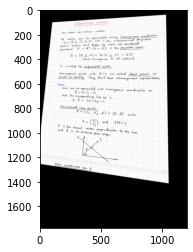

In [134]:
# Warping the image according to homography
img_warp = cv.warpPerspective(img, H, (img.shape[1], img.shape[0]))

plt.imshow(img_warp[:,:,::-1])
plt.show()

## Non-linear transformations

This is a warping by a non-linear function. This warping does not resembles the
real behavior in a traditional warping.

First step: resize and translate


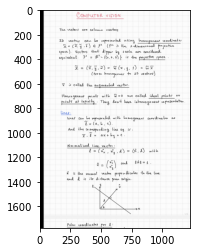

Second step: warp


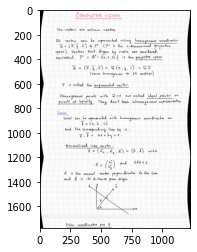

(1776, 1230, 3)
Third step: rotate


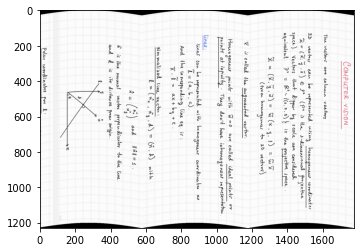

In [135]:
height = 30

# First we need to translate the image by a height
mat_trans = np.array([
    [1, 0, height],
    [0, 1, 0]
]).astype(np.float32)

img_trans = cv.warpAffine(img, mat_trans, (img.shape[1] + height, img.shape[0]))

print("First step: resize and translate")
plt.imshow(img_trans[:, :, ::-1])
plt.show()

# Now we warp the image according to a non-linear function
img_dst = np.zeros((img.shape[0], img.shape[1] + height, img.shape[2]),
                   dtype=img.dtype)

for i in range(img_trans.shape[0]):
    for j in range(img_trans.shape[1]):
        offset_x = int(np.abs(
            height * np.sin(2 * np.pi * i / (img.shape[1]))))
        
        if j + offset_x < img_trans.shape[1]:
            img_dst[i, j] = img_trans[i, j + offset_x]
        else:
            img_dst[i, j] = 0

print("Second step: warp")            
plt.imshow(img_dst[:, :, ::-1])
plt.show()

print(img_dst.shape)

# We apply a rotation of the image
img_rot = cv.rotate(img_dst, cv.ROTATE_90_CLOCKWISE)

print("Third step: rotate")            
plt.imshow(img_rot[:, :, ::-1])
plt.show()

## Grid model

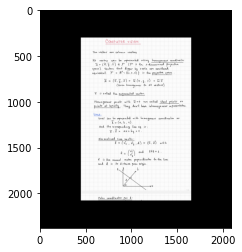

In [354]:
# Enlarge the image
excess_height = img.shape[1] * 1 // 4
excess_width = img.shape[0] * 1// 4
img_resize = cv.copyMakeBorder(img, excess_height, excess_height, excess_width,
                               excess_width, borderType=cv.BORDER_CONSTANT,
                               value=(0, 0, 0))

plt.imshow(img_resize[:, :, ::-1])
plt.show()

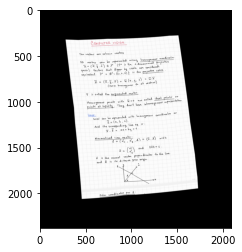

True

In [356]:
def construct_random_mesh(width, height, max_rand_mov, max_str, curved_norm):
    """Source code taken and adapted from 
    https://github.com/mhashas/Document-Image-Unwarping-pytorch/issues/7"""
    
    x_axis = np.arange(0, width, 1)
    y_axis = np.arange(0, height, 1)
    x_mesh, y_mesh = np.meshgrid(x_axis, y_axis)

    # Generates the mesh without modifications, only the points
    perturbed_mesh = np.transpose(np.asarray([x_mesh.flatten("F"), 
                                           y_mesh.flatten("F")]))
    
    n_variations = np.random.randint(max_rand_mov)
    for _ in range(n_variations):
        # Choose a vertex at random
        rnd_point_idx = np.random.randint(perturbed_mesh.shape[0])
        rnd_point = perturbed_mesh[rnd_point_idx, :]
        
        # This vector gives the direction and strength of the deformation
        v = (np.random.rand(1, 2) - 0.5) * max_str
        
        # Compute the distance from every point to the line rnd_point + t * v
        difference = rnd_point - perturbed_mesh
        cross_v_difference = np.cross(v, difference)
        d = np.abs(cross_v_difference) / np.linalg.norm(v, ord=2)
        
        # Choice at random if perform curved or linear deformation
        is_linear = np.random.rand()
        if is_linear < 0.7:
            alpha = np.random.uniform(100, 150)
            w = alpha / (d + alpha)
        else:
            alpha = np.random.uniform(low=1, high=2)
            w = 1 - np.power(d / curved_norm, alpha)
            
        # Resize w to match element wise multiplication
        reshaped_w = w.reshape((w.shape[0], 1))
        duplicated_w = np.append(reshaped_w, reshaped_w, axis=1)
        
        # Make modification to the mesh
        perturbed_mesh = perturbed_mesh + duplicated_w * v
        
    return perturbed_mesh


# Syntetic deformation params
MAX_STRENGTH = 20
MAX_RANDOM_MOV = 19
CURVED_NORMALIZER = 250

mesh = construct_random_mesh(img_resize.shape[0], img_resize.shape[1],
                             MAX_RANDOM_MOV, MAX_STRENGTH, CURVED_NORMALIZER)

# ==========================
# To show the perturbed mesh
# ==========================
# plt.scatter(mesh[:, 0], mesh[:, 1], 
#            c=np.arange(0, img_resize.shape[0] * img_resize.shape[1]))
# plt.show()
# ==========================

# Transform image
x_mesh_pert = mesh[:, 1].reshape(img_resize.shape[0], 
                                 img_resize.shape[1]).astype(np.float32)
y_mesh_pert = mesh[:, 0].reshape(img_resize.shape[0], 
                                 img_resize.shape[1]).astype(np.float32)

perturbed_image = cv.remap(img_resize, x_mesh_pert, y_mesh_pert,
                           cv.INTER_LINEAR)

plt.imshow(perturbed_image[:, :, ::-1])
plt.show()

cv.imwrite("../assets/handwritten_warped.jpg", perturbed_image)

## Constructing our variation

Here, we will warp the page following the pinhole model and the function
$b(x) = \omega x \exp(-\lambda x)$ to model the profile of the warped page

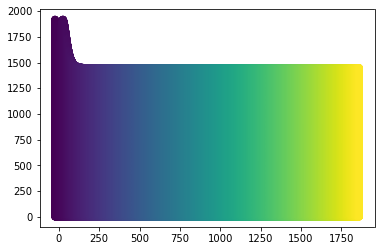

In [341]:
def profile_fn(x, omega, lambd, x_displ):
    return omega * np.abs(x - x_displ) * np.exp(-lambd * np.abs(x - x_displ))

def project_point(x, y, foc_dist, obj_dist, omega, lambd, x_displ):
    u = foc_dist * (x - x_displ) / (obj_dist - profile_fn(x, omega, lambd, x_displ))
    v = foc_dist * y / (obj_dist - profile_fn(x, omega, lambd, x_displ))
    return u, v

def construct_own_mesh(width, height, foc_dist, obj_dist, omega, lambd, 
                       x_displ):
    x_axis = np.arange(0, width, 1)
    y_axis = np.arange(0, height, 1)
    x_mesh, y_mesh = np.meshgrid(x_axis, y_axis)

    # Generates the mesh without modifications, only the points
    normal_mesh = np.transpose(np.asarray([x_mesh.flatten("F"), 
                                           y_mesh.flatten("F")]))
    perturbed_mesh = []

    for point in normal_mesh:
        u, v = project_point(*point, foc_dist, obj_dist, omega, lambd, x_displ)
        perturbed_mesh.append([u, v])

    return np.array(perturbed_mesh)


# Own deformation params
FOC_DIST = 14
OBJ_DIST = 15
OMEGA = 0.5
LAMBDA = 0.05
X_DISPL = 20

mesh = construct_own_mesh(img_resize.shape[0], img_resize.shape[1], FOC_DIST,
                          OBJ_DIST, OMEGA, LAMBDA, X_DISPL)

# ==========================
# To show the perturbed mesh
# ==========================
plt.scatter(mesh[:, 0], mesh[:, 1], 
           c=np.arange(0, img_resize.shape[0] * img_resize.shape[1]))
plt.show()
# ==========================